In [123]:
import matplotlib.pyplot as plt # plotting
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import json
import networkx as nx
import re
import pickle
from scipy.spatial.distance import pdist

Use the theory and tools illustrated in week 4, to measure the extent to which the network of communication between Star Wars characters exhibits homophily with respect to the categories 'humans' and 'other sentient species'.

In [7]:
with open('starwars-full-interactions-allCharacters.json') as f:
    data = json.load(f)
print(data['nodes'][0])
print(data['links'][0])

{'name': 'R2-D2', 'value': 171, 'colour': '#bde0f6'}
{'source': 1, 'target': 0, 'value': 17}


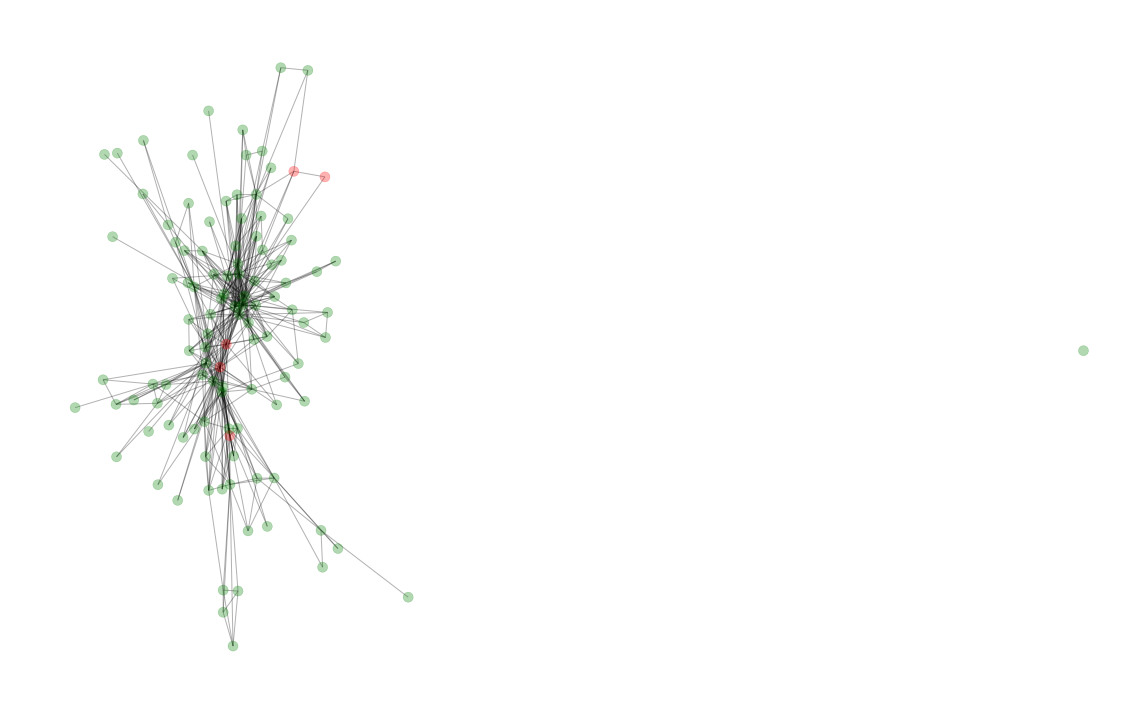

In [125]:
G = nx.Graph()
fig=plt.figure(figsize=(18,12))
fig.add_subplot(111)
#build graph nodes
for node in data['nodes']:
    G.add_node(node['name'])
#build graph edges
for edge in data['links']:
    G.add_edge(data['nodes'][edge['source']]['name'], 
               data['nodes'][edge['target']]['name'],
               weight=edge['value'])
nx.draw(G,node_size=100,alpha=0.3,node_color=node_color)

In [14]:
print((len(G.edges()))

450


In [15]:
print(len(G.nodes()))

112


Divide nodes into 2 categories: humans and others

In [77]:
def human_or_other_color(g):
    node_color=[]
    for i in g.nodes():
        if any(char.isdigit() for char in i):
            node_color.append('red')
        else:
            node_color.append('green')
    return node_color

In [78]:
def human_or_other(g):
    humans=[]
    for a in g.nodes():
        if any(char.isdigit() for char in a):
            humans.append(0)
        else:
            humans.append(1)
    return humans

In [79]:
node_color=human_or_other_color(G)
human_or_other=human_or_other(G)
proportion=sum(human_or_other)/len(human_or_other)

In [80]:
proportion

0.9553571428571429

In [117]:
GG=nx.to_numpy_array((G))
GG

array([[ 0., 17.,  2., ...,  0.,  0.,  0.],
       [17.,  0.,  8., ...,  0.,  0.,  0.],
       [ 2.,  8.,  0., ...,  0.,  0.,  0.],
       ...,
       [ 0.,  0.,  0., ...,  0.,  2.,  2.],
       [ 0.,  0.,  0., ...,  2.,  0.,  2.],
       [ 0.,  0.,  0., ...,  2.,  2.,  0.]])

In [121]:
# %% style issues
plt.style.use('fivethirtyeight')
np.random.seed(000)
# nodes
n = len(G.nodes())
# proportion of human nodes
p = proportion
# tie formation probabilities
p_hh = 0.25
p_oo = 0.20
p_ho = 0.01
# size of the sub-components of the adjacency
size=(int(n*p), int(n*p))

# let's assume the observed network exhibits sharp human segregation
hh = np.random.binomial(1, p_hh, size=size)
oo = np.random.binomial(1, p_oo, size=size)
ho = np.random.binomial(1, p_ho, size=size)
oh = np.transpose(ho)

# the graph
#g_left, g_right = np.vstack((hh, oh)), np.vstack((ho, oo))
g = GG
# fill diagonal values with 0s - we're not interested in the relationship
# a node has with itself
np.fill_diagonal(g, 0)

# count of female-female ties
c_hh = np.sum(hh)

# count of female-male or male-female ties
c_ho = 2 * np.sum(ho)

# count of male-male ties
c_oo = np.sum(oo)

# %% compare the focal network against 1,000 simulated networks

# define function
def assess_hompohily(_g,
                     _p,
                     _n,
                     _c_hh, _c_oo, _c_ho,
                     _n_iterations):
    '''
    :param _g: observed network (adjaceny matrix -- pass  a Numpy array)
    :param _p: proportion of humans = others nodes in the network
    :param _n: count of nodes in network
    :param _c_ff: count of human-femhumanale ties in the observed network
    :param _c_mm: count of other-other ties in the observed network
    :param _c_fm: count of human - ither ties in the observed network
    :param _n_iterations: count
    :return: list of cosine similarity scores along with descriptive
             statistics
    '''

    # fix seed
    np.random.seed(000)

    # containers
    # --+ count ties by type (homophilous Vs heterophilous)
    _r_hh, _r_ho, _r_oo = 0, 0, 0
    # --+ distance between observed and simulated data
    _dist = []

    for iteration in range(_n_iterations):
        _reshuffled = np.random.binomial(1, p, size=n)
        for i in range(n):
            for j in range(n):
                # --+ sample the tie in the network
                t = [g[i][j]][0]
                # --+ if tie is present, evaluate whether it's a homphilous or
                # --- heterophilous tie based on the reshuffled network
                if t >0:
                    h = np.sum([_reshuffled[i], _reshuffled[j]])
                    if h == 2:
                        _r_hh += 1
                    elif h == 1:
                        _r_ho += 1
                    elif h == 0:
                        _r_oo += 1
                    else:
                        pass
                else:
                    pass

        # get the distance between the observed and simulated distribution
        # of ties with respect to three following categories: (i)
        # female-female; (ii) female-male; (iii) male-male. Scipy doc is the
        # place start to get a closer understanding of `cosine similarity'
        # as a distance metric (see scipy.spatial.distance).
        _observed = np.array([c_hh, c_ho, c_oo])
        _simulated = np.array([_r_hh, _r_ho, _r_oo])
        to_append = pdist([_observed, _simulated], metric='cosine')
        _dist.append(to_append[0])

    # return statistics on the distance between the observed and siimulated
    # distributions of ties with respect to type (homophilopus Vs.
    # heterophilous)
    # --+
    _mean, _std, _min, _max = np.mean(_dist), np.std(_dist),\
                              np.min(_dist), np.max(_dist)
    print(80 * '-',
          'Descriptive statistics on observed-simulated ' \
          'distances',
          80 * '-',
          'Mean: %s' % np.round(_mean, 2),
          'Std. dev.: %s' % np.round(_std, 2),
          'Min: %s' % np.round(_min, 2),
          'Max: %s' % np.round(_max, 2),
          end='\n',
          sep='\n')
    # --+ plot the distribution of sum of squares
    fig = plt.figure(figsize=(6, 4))
    ax = fig.add_subplot(1, 1, 1)
    ax.hist(_dist,
            bins=50, cumulative=False, density=False,
            color='orange', alpha=0.5,
            histtype='bar')
    ax.set_xlabel(r'Cosine similarity')
    ax.set_ylabel(r'Count of simulation runs')
    ax.set_title(r'Exploring homophily in graph G')
    # --+ save figure
    plt.tight_layout()
    plt.savefig('cosine_sim_distr.pdf')
    # --+ return objects
    return(_dist, [_mean, _std, _min, _max])

--------------------------------------------------------------------------------
Descriptive statistics on observed-simulated distances
--------------------------------------------------------------------------------
Mean: 0.23
Std. dev.: 0.0
Min: 0.22
Max: 0.23


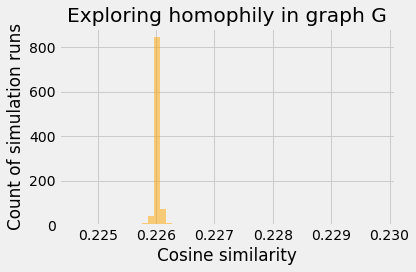

In [124]:
outcome = assess_hompohily(_g=g, _p=p, _n=n,
                           _c_oo=c_oo, _c_hh=c_hh, _c_ho=c_ho,
                           _n_iterations=1000)

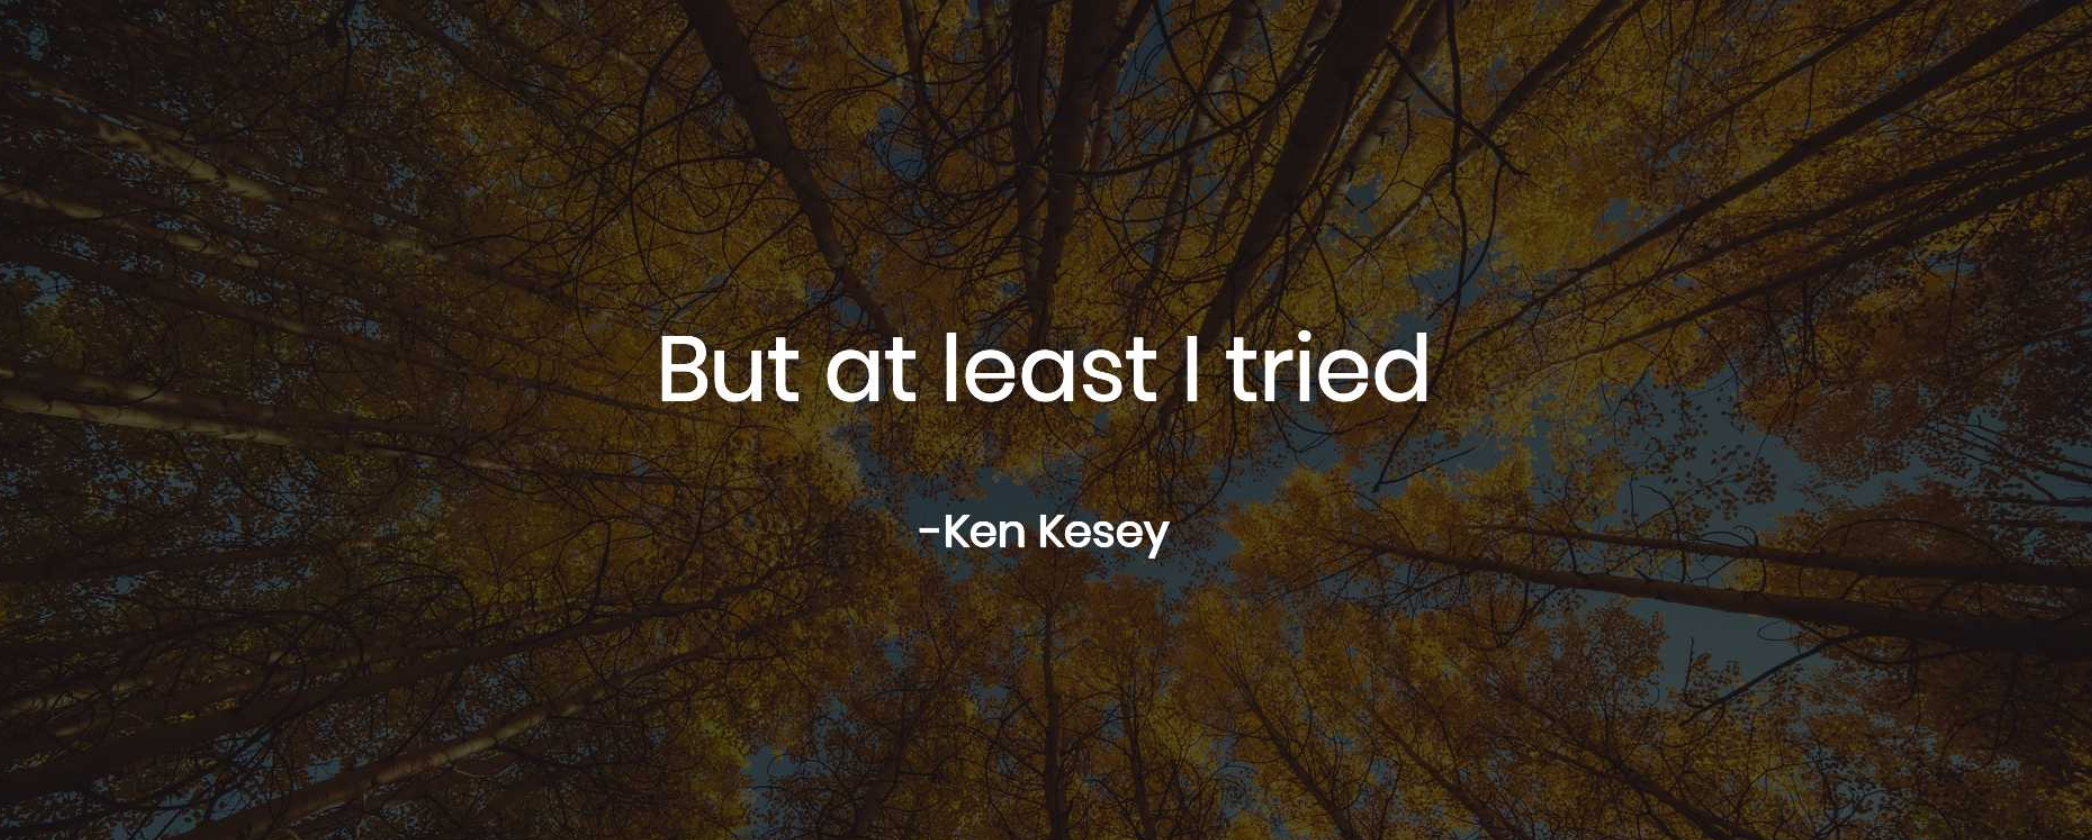